In [123]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [214]:
def get_best_thresh(df, col_name):
    # Filter out NaN values in the specified column and 'generated' column
    df_clean = df.dropna(subset=[col_name, 'generated'])
    
    best_thresh = 0
    best_acc = 0
    best_direction = '>'

    thresholds = sorted(df_clean[col_name].unique())

    for t in thresholds:
        # For '>' direction
        preds_gt = (df_clean[col_name] > t).astype(int)
        acc_gt = accuracy_score(df_clean['generated'], preds_gt)

        # For '<' direction
        preds_lt = (df_clean[col_name] < t).astype(int)
        acc_lt = accuracy_score(df_clean['generated'], preds_lt)

        # Update best threshold and accuracy for '>' direction
        if acc_gt > best_acc:
            best_acc = acc_gt
            best_thresh = t
            best_direction = '>'

        # Update best threshold and accuracy for '<' direction
        if acc_lt > best_acc:
            best_acc = acc_lt
            best_thresh = t
            best_direction = '<'

    return [best_thresh, best_acc, best_direction]



In [ ]:
df = pd.read_csv("../data/score_dataset.csv")
df.head()

,text,generated,pred score
0,Limiting car usage can have several advantages...,1,1.492491
1,"""America's love affair with it's vehicles seem...",0,0.919343
2,Reducing the usage of cars in today's world co...,0,0.953056
3,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,0.772685
4,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,1.132379


In [ ]:
df1 = pd.read_csv("../data/score_diffusion_dataset.csv")
df1.head()
df.rename(columns={'pred score': 'score basic'}, inplace=True)
df['score with diffusion'] = df1['score_with_diffusion']
df['score without diffusion'] = df1['score_without_diffusion']

In [217]:
df.head()

,text,generated,score basic,score with diffusion,score without diffusion
0,Limiting car usage can have several advantages...,1,1.492491,-0.537769,-6.113869e+01
1,"""America's love affair with it's vehicles seem...",0,0.919343,1.075490,9.730217e-01
2,Reducing the usage of cars in today's world co...,0,0.953056,1.538736,2.690150e+00
3,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,0.772685,-0.169041,-8.213293e+01
4,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,1.132379,-1.643560,-1.193706e+08


In [ ]:
def add_scores_to_df(df, file_path, col):
    # Step 1: Read the numbers from the text file
    with open(file_path, 'r') as file:
        scores = [float(line.strip()) for line in file]
    print(len(scores))

    # Step 2: Add the list as a new column to the DataFrame, filling with NaN if the list is shorter
    df[col] = scores + [np.nan] * (len(df) - len(scores))
    
    return df

# Assuming df is your DataFrame and 'scores.txt' is the file containing the numbers
df = add_scores_to_df(df, '../data/my_numbers.txt', 'score with BERT')
df = add_scores_to_df(df, '../data/numbers.txt', 'score with BERT and ARD-RBF')

550
463


In [221]:
n = len(df.columns)
for col in df.columns[2:n]:
    best_thresh, best_acc, direction = get_best_thresh(df, col)
    print(f'Best accuracy for {col} is {best_acc:.2f} with threshold {best_thresh:.4f} ({direction})')
    
    suffix = col.replace("score ", "")
    if direction == '>':
        df[f"predicted {suffix}"] = (df[col] > best_thresh).astype(int)
    else:
        df[f"predicted {suffix}"] = (df[col] < best_thresh).astype(int)

Best accuracy for score basic is 0.76 with threshold 0.9612 (>)
Best accuracy for score with diffusion is 0.74 with threshold -0.0576 (>)
Best accuracy for score without diffusion is 0.76 with threshold -0.0024 (>)
Best accuracy for score with BERT is 0.83 with threshold -0.0000 (>)
Best accuracy for score with BERT and ARD-RBF is 0.83 with threshold -0.0020 (>)


In [222]:
df.head()

,text,generated,score basic,score with diffusion,score without diffusion,score with BERT,score with BERT and ARD-RBF,predicted basic,predicted with diffusion,predicted without diffusion,predicted with BERT,predicted with BERT and ARD-RBF
0,Limiting car usage can have several advantages...,1,1.492491,-0.537769,-6.113869e+01,1.289356,0.430823,1,0,0,1,1
1,"""America's love affair with it's vehicles seem...",0,0.919343,-1.075490,9.730217e-01,-0.124147,-0.683076,0,0,1,0,0
2,Reducing the usage of cars in today's world co...,0,0.953056,-1.538736,-2.690150e+00,-1.725720,-0.451198,0,0,0,0,0
3,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,0.772685,0.169041,8.213293e+01,0.192478,-0.560247,0,1,1,1,0
4,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,1.132379,-1.643560,1.193706e+08,1.358722,0.215381,1,0,1,1,1


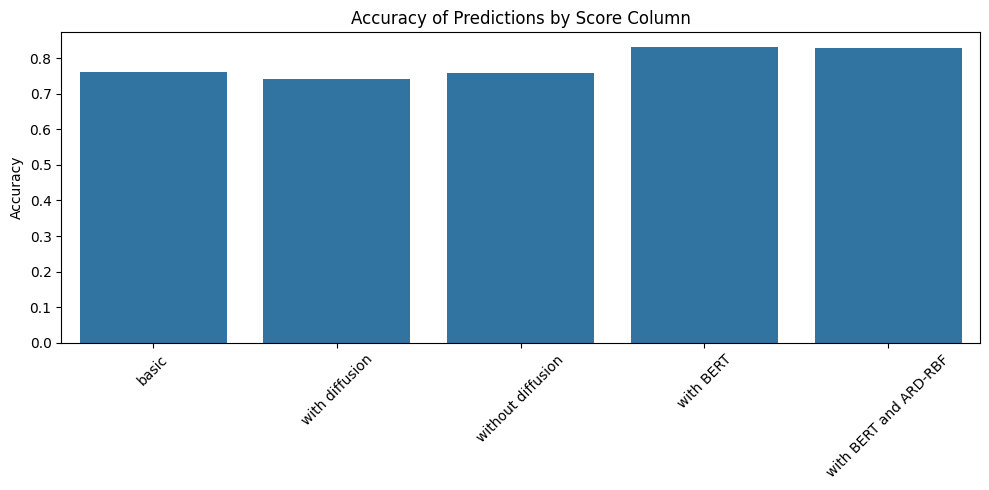

In [223]:
accuracies = []
columns = []

for col in df.columns[2:n]:
    best_thresh, best_acc, direction = get_best_thresh(df, col)
    suffix = col.replace("score ", "")
    columns.append(suffix)
    accuracies.append(best_acc)

# Plot histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=columns, y=accuracies)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Accuracy of Predictions by Score Column")
plt.tight_layout()
plt.show()

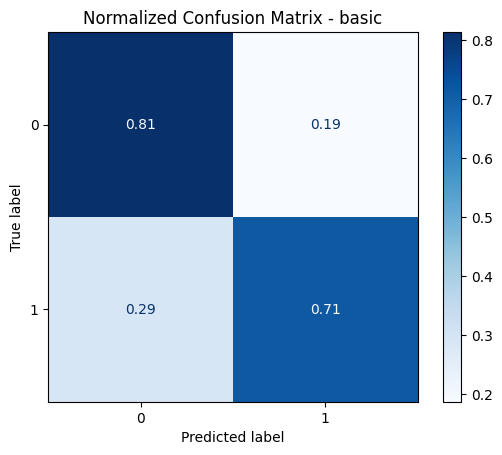

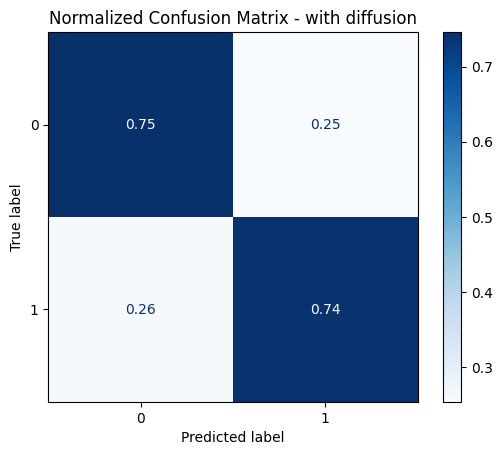

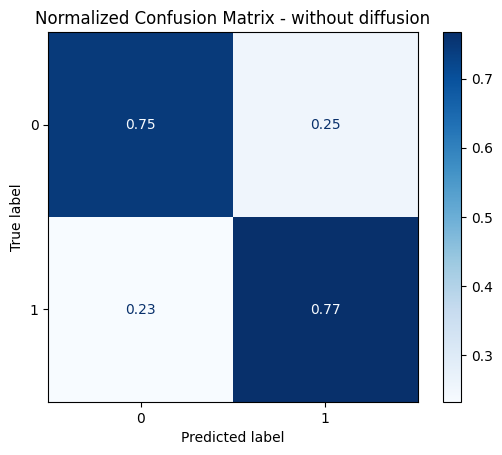

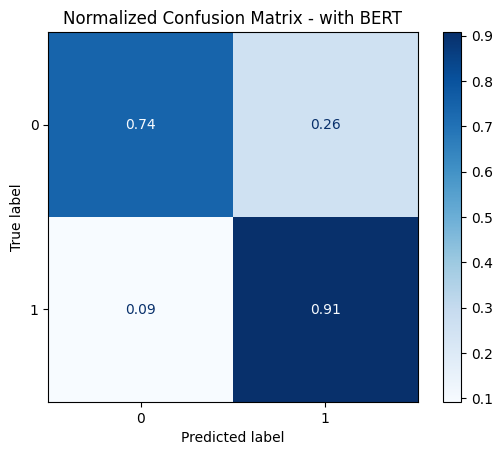

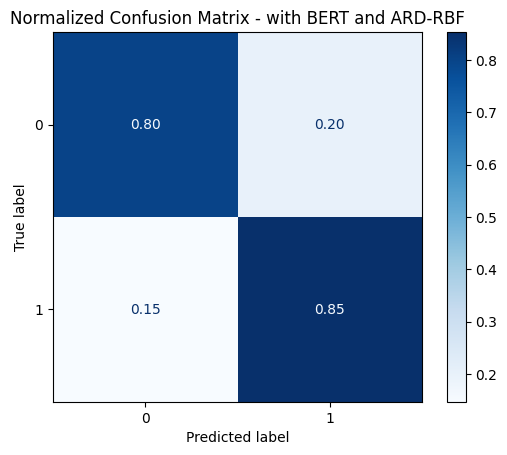

In [224]:
for col in df.columns[n:]:
    suffix = col.replace("predicted ", "")
    score_col = f"score {suffix}"  # Assumes 'score ' columns match suffix

    if score_col not in df.columns:
        continue  # Skip if the corresponding score column doesn't exist

    y_true = df['generated']
    y_pred = df[col]
    score_vals = df[score_col]

    # Mask: valid only if both y_pred and score_col are not NaN
    valid_mask = y_pred.notna() & score_vals.notna()

    # Filtered values
    y_true_filtered = y_true[valid_mask]
    y_pred_filtered = y_pred[valid_mask]

    if len(y_true_filtered) == 0:
        continue  # Skip if there's no valid data to compare

    # Normalized confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format=".2f")
    plt.title(f"Normalized Confusion Matrix - {suffix}")
    plt.show()

In [ ]:
df.to_csv('../data/final_scores_and_predictions.csv')